## Import necessary libraries

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model, layers
from tensorflow.keras.utils import Sequence
import numpy as np
import cv2
import math

In [2]:
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    gpu0 = gpus[0] # Only use GPU 0 when existing multiple GPUs
    tf.config.experimental.set_memory_growth(gpu0, True) # Set the usage of GPU memory according to needs
    # The GPU memory usage could also be fixed (e.g. 4GB)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU") 

2023-08-07 15:55:19.820325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-07 15:55:19.820525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-07 15:55:19.845816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/airi/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-08-07 15:55:19.845835: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https:/

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Binary alpha digits

In [17]:
dataset = tfds.load('binary_alpha_digits', split='train')
x_data, y_data = [], []
for i in dataset:
    a = i['image'].numpy()
    x_data.append(a.astype(np.float32))
    y_data.append(i['label'].numpy().astype(np.float32))

x_train, y_train, x_test, y_test = x_data[:1000], y_data[:1000], x_data[1000:], y_data[1000:]

In [18]:
train = tf.data.Dataset.from_tensor_slices(dict(x=x_train, y=y_train)).repeat().batch(16)
test = tf.data.Dataset.from_tensor_slices(dict(x=x_test, y=y_test)).repeat().batch(16)
train = iter(train)
test = iter(test)

In [9]:
class NeuralNet(Model):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv1 = layers.Conv2D(16, 3, padding='same', activation=tf.nn.relu)
        self.conv2 = layers.Conv2D(32, 3, padding='same', activation=tf.nn.relu)
        self.maxpool = layers.MaxPool2D()
        self.batch1 = layers.BatchNormalization()
        self.batch2 = layers.BatchNormalization()
        self.flat = layers.Flatten()
        self.fc1 = layers.Dense(256, activation=tf.nn.relu)
        self.fc2 = layers.Dense(64, activation=tf.nn.relu)
        self.out = layers.Dense(36)

    def call(self, x, is_training=False):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.maxpool(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        x = tf.nn.softmax(x)
        return x

In [10]:
model = NeuralNet()
model.build(input_shape=(1, 20, 16, 1))
model.summary()

Model: "neural_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  160       
                                                                 
 conv2d_1 (Conv2D)           multiple                  4640      
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 batch_normalization (BatchN  multiple                 64        
 ormalization)                                                   
                                                                 
 batch_normalization_1 (Batc  multiple                 128       
 hNormalization)                                                 
                                                        

In [14]:
# set optimizer and loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(ckpt, './checkpoints', max_to_keep=3)

In [25]:
@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        output = model(data['x'])
        loss = loss_object(data['y'], output)
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    train_loss(loss)
    train_accuracy(data['y'], output)
    return loss

@tf.function
def test_step(data):
    predictions = model(data['x'], training=False)
    t_loss = loss_object(data['y'], predictions)
    
    test_loss(t_loss)
    test_accuracy(data['y'], predictions)
    return t_loss

In [31]:
# Training process
def train_and_checkpoint(model, manager):
    for _ in range(math.ceil(len(x_train)/16)):
        example = next(train)
        loss = train_step(example)
        ckpt.step.assign_add(1)
        if int(ckpt.step) % 10 == 0:
            save_path = manager.save()
          # print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
          # print("loss {:1.2f}".format(loss.numpy()))

epochs = 100

ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

for i in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    train_and_checkpoint(model, manager)
    for _ in range(math.ceil(len(x_test)/16)):
        example = next(test)
        test_step(example)
    if i % 10 == 0:
        print(
          f'Epoch {i}, '
          f'Loss: {train_loss.result()}, '
          f'Accuracy: {train_accuracy.result() * 100}, '
          f'Test Loss: {test_loss.result()}, '
          f'Test Accuracy: {test_accuracy.result() * 100}'
      )

Restored from ./checkpoints\ckpt-638
Epoch 0, Loss: 2.8544511795043945, Accuracy: 77.48016357421875, Test Loss: 2.9797961711883545, Test Accuracy: 65.14422607421875
Epoch 10, Loss: 2.856266975402832, Accuracy: 77.28174591064453, Test Loss: 2.9792847633361816, Test Accuracy: 65.14422607421875
Epoch 20, Loss: 2.881319046020508, Accuracy: 75.0, Test Loss: 3.0111069679260254, Test Accuracy: 62.259613037109375
Epoch 30, Loss: 2.836782455444336, Accuracy: 79.26587677001953, Test Loss: 2.9695792198181152, Test Accuracy: 65.86538696289062
Epoch 40, Loss: 2.8248403072357178, Accuracy: 80.45634460449219, Test Loss: 2.965595006942749, Test Accuracy: 66.34615325927734
Epoch 50, Loss: 2.823812246322632, Accuracy: 80.55555725097656, Test Loss: 2.9644620418548584, Test Accuracy: 66.10577392578125
Epoch 60, Loss: 2.821666955947876, Accuracy: 80.75396728515625, Test Loss: 2.9620373249053955, Test Accuracy: 66.58653259277344
Epoch 70, Loss: 2.815594434738159, Accuracy: 81.64682006835938, Test Loss: 2.95

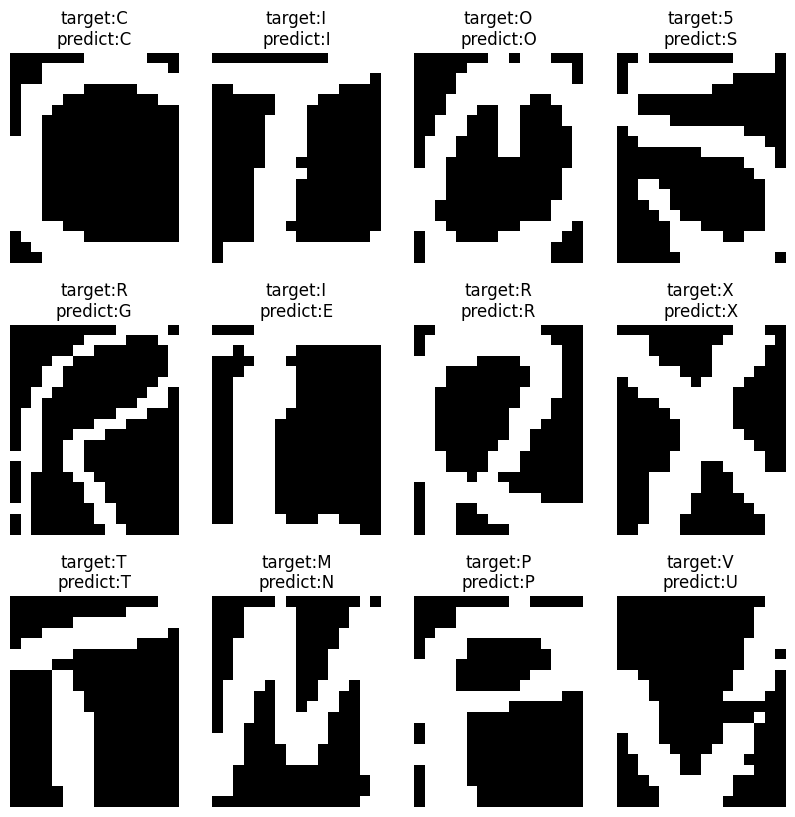

In [46]:
# test model with test dataset

classes = [str(i) for i in range(10)]
for i in range(65, 91):
    classes.append(chr(i))

# Visualize predictions.
import matplotlib.pyplot as plt
# Predict 5 images from validation set.
n_images = 12
test_images = next(test)
predictions = model(test_images['x'])
plt.figure(figsize=(10, 10))
# Display image and model prediction.
for i in range(n_images):
    plt.subplot(3,4,i+1)
    plt.imshow(test_images['x'][i], cmap='gray')
    plt.axis('off')
    plt.title('target:'+classes[int(test_images['y'][i])]+'\n'+'predict:'+classes[np.argmax(predictions.numpy()[i])])

Prediction: 7 N
Targets: J 8


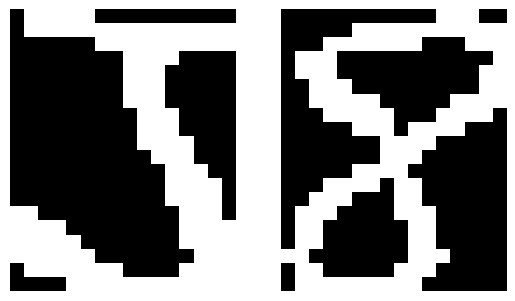

In [57]:
plt.subplot(121)
plt.imshow(x_test[4], cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(x_test[5], cmap='gray')
plt.axis('off')

ckpt.restore(manager.latest_checkpoint)

pred = np.argmax(modelmb(np.array(x_test[4:6])), axis=1)
print("Prediction:", classes[pred[0]], classes[pred[1]])
print('Targets:', classes[int(y_test[4])], classes[int(y_test[5])])

## Deep_weeds

In [2]:
dataset = tfds.load('deep_weeds', split='train')

x_data, y_data = [], []
for i in dataset:
    a = i['image'].numpy()
    x_data.append(cv2.resize(a, (224, 224))/255.0)
    y_data.append(i['label'].numpy())

x_train, y_train, x_test, y_test = x_data[:15000], y_data[:15000], x_data[15000:], y_data[15000:]
del x_data, y_data
len(x_train), len(y_train), len(x_test), len(y_test)

2023-08-07 16:08:03.561383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-07 16:08:03.561585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-07 16:08:03.587215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/airi/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-08-07 16:08:03.587233: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https:/

(15000, 15000, 2509, 2509)

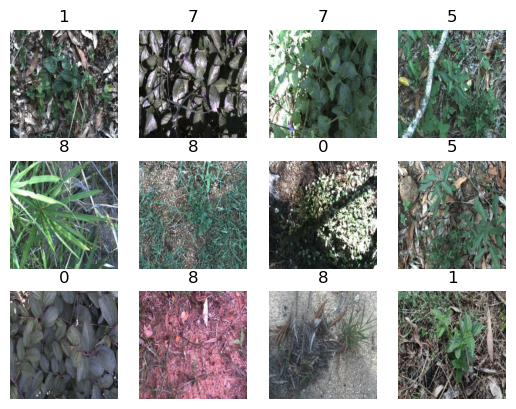

In [3]:
import matplotlib.pyplot as plt

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow((x_train[i]*255).astype(np.uint8))
    plt.title(y_train[i])
    plt.axis('off')

In [5]:
train = tf.data.Dataset.from_tensor_slices(dict(x=x_train, y=y_train)).repeat().batch(16)
test = tf.data.Dataset.from_tensor_slices(dict(x=x_test, y=y_test)).repeat().batch(16)
train = iter(train)
test = iter(test)

In [6]:
# define model
class NN(Model):
    def __init__(self):
        super(NN, self).__init__()
        self.base_model = tf.keras.applications.ResNet50(weights="imagenet",
                                                         input_shape=(224, 224, 3),
                                                         include_top=False)
        self.base_model.trainable = False
        self.apool = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(1024, activation=tf.nn.relu)
        self.fc2 = layers.Dense(128, activation=tf.nn.relu)
        self.out = layers.Dense(9, activation=tf.nn.softmax)
        
    def call(self, x, is_training=False):
        x = self.base_model(x)
        x = self.apool(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x

In [13]:
# create model and set optimizer, loss
model = NN()
model.build((1,224,224,3))

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(ckpt, './dw_checkpoints', max_to_keep=3)

model.summary()

Model: "nn_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   multiple                 0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             multiple                  2098176   
                                                                 
 dense_7 (Dense)             multiple                  131200    
                                                                 
 dense_8 (Dense)             multiple                  1161      
                                                                 
Total params: 25,818,249
Trainable params: 2,230,537
Non-trainable params: 23,587,712
__________________________________________

In [14]:
@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        output = model(data['x'])
        loss = loss_object(data['y'], output)
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    train_loss(loss)
    train_accuracy(data['y'], output)
    return loss

@tf.function
def test_step(data):
    predictions = model(data['x'], training=False)
    t_loss = loss_object(data['y'], predictions)
    
    test_loss(t_loss)
    test_accuracy(data['y'], predictions)
    return t_loss

In [16]:
# Training process
def train_and_checkpoint(model, manager):
    for _ in range(math.ceil(len(x_train)/16)):
        example = next(train)
        loss = train_step(example)
        ckpt.step.assign_add(1)
        if int(ckpt.step) % 10 == 0:
            save_path = manager.save()
          # print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
          # print("loss {:1.2f}".format(loss.numpy()))

epochs = 10

ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

for i in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    train_and_checkpoint(model, manager)
    for _ in range(math.ceil(len(x_test)/16)):
        example = next(test)
        test_step(example)
    print(
      f'Epoch {i}, '
      f'Loss: {train_loss.result()}, '
      f'Accuracy: {train_accuracy.result() * 100}, '
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Restored from ./checkpoints/ckpt-927
Epoch 0, Loss: 1.2831242084503174, Accuracy: 54.99067306518555, Test Loss: 1.381269931793213, Test Accuracy: 53.58280563354492
Epoch 1, Loss: 1.272148609161377, Accuracy: 55.337154388427734, Test Loss: 1.3739323616027832, Test Accuracy: 53.62260818481445
Epoch 2, Loss: 1.2542946338653564, Accuracy: 55.656982421875, Test Loss: 1.3784559965133667, Test Accuracy: 54.10031509399414
Epoch 3, Loss: 1.2434673309326172, Accuracy: 55.72361373901367, Test Loss: 1.3914813995361328, Test Accuracy: 53.5031852722168
Epoch 4, Loss: 1.2327035665512085, Accuracy: 56.569828033447266, Test Loss: 1.4208152294158936, Test Accuracy: 53.54299545288086
Epoch 5, Loss: 1.2221028804779053, Accuracy: 56.549842834472656, Test Loss: 1.3592016696929932, Test Accuracy: 54.29936218261719
Epoch 6, Loss: 1.210739254951477, Accuracy: 57.002933502197266, Test Loss: 1.376308798789978, Test Accuracy: 53.5031852722168
Epoch 7, Loss: 1.2014148235321045, Accuracy: 57.3094367980957, Test Los

In [17]:
tf.saved_model.save(model, 'models/deepweeds')

INFO:tensorflow:Assets written to: models/deepweeds/assets


INFO:tensorflow:Assets written to: models/deepweeds/assets


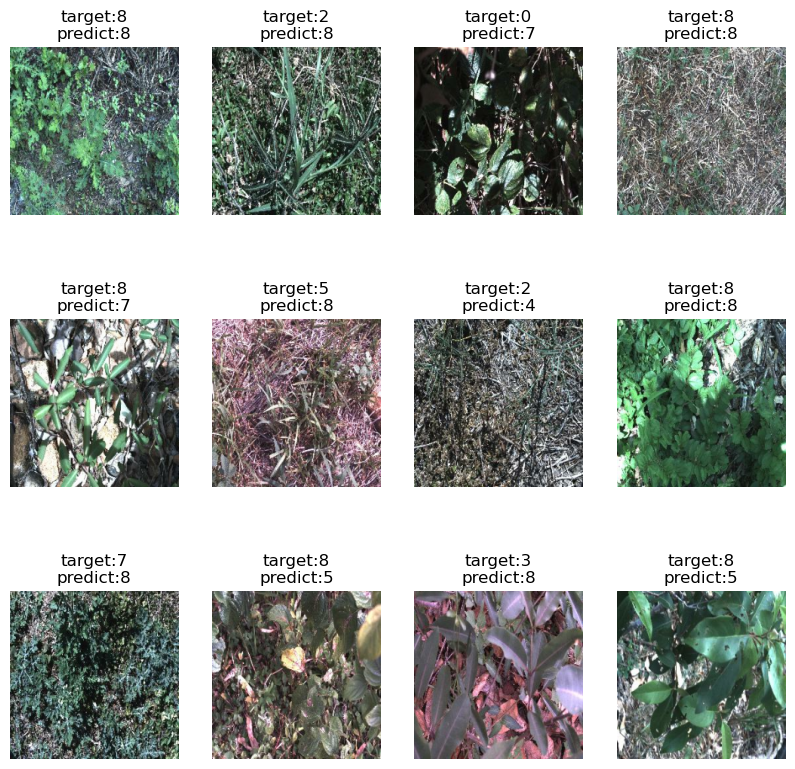

In [18]:
# Visualize predictions.
import matplotlib.pyplot as plt
# Predict 5 images from validation set.
n_images = 12
test_images = next(test)
predictions = model(test_images['x'])
plt.figure(figsize=(10, 10))
# Display image and model prediction.
for i in range(n_images):
    plt.subplot(3, 4, i+1)
    plt.imshow(test_images['x'][i], cmap='gray')
    plt.axis('off')
    plt.title('target:'+str(y_test[i])+'\n'+'predict:'+str(np.argmax(predictions.numpy()[i])))

### Horses_or_humans

In [19]:
dataset = tfds.load('horses_or_humans')
train, test = dataset['train'], dataset['test']

x_train, y_train, x_test, y_test = [], [], [], []
for i in train:
    a = i['image'].numpy()/255.0
    x_train.append(cv2.resize(a, (224, 224)))
    y_train.append(i['label'].numpy())
    
for i in test:
    a = i['image'].numpy()/255.0
    x_test.append(cv2.resize(a, (224, 224)))
    y_test.append(i['label'].numpy())

len(x_train), len(y_train), len(x_test), len(y_test)

(1027, 1027, 256, 256)

In [21]:
train = tf.data.Dataset.from_tensor_slices(dict(x=x_train, y=y_train)).repeat().batch(16)
test = tf.data.Dataset.from_tensor_slices(dict(x=x_test, y=y_test)).repeat().batch(16)
train = iter(train)
test = iter(test)

In [22]:
class NN(Model):
    def __init__(self):
        super(NN, self).__init__()
        self.base_model = tf.keras.applications.MobileNet(weights="imagenet",
                                                         input_shape=(224, 224, 3),
                                                         include_top=False)
        self.base_model.trainable = False
        self.apool = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(512, activation=tf.nn.relu)
        self.fc2 = layers.Dense(128, activation=tf.nn.relu)
        self.out = layers.Dense(1, activation=tf.nn.sigmoid)
        
    def call(self, x, is_training=False):
        x = self.base_model(x)
        x = self.apool(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x

In [23]:
model = NN()

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(ckpt, './hah_checkpoints', max_to_keep=3)

@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        output = model(data['x'])
        loss = loss_object(data['y'], output)
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    train_loss(loss)
    train_accuracy(data['y'], output)
    return loss

@tf.function
def test_step(data):
    predictions = model(data['x'], training=False)
    t_loss = loss_object(data['y'], predictions)
    
    test_loss(t_loss)
    test_accuracy(data['y'], predictions)
    return t_loss

In [24]:
# Training process
def train_and_checkpoint(model, manager):
    for _ in range(math.ceil(len(x_train)/16)):
        example = next(train)
        loss = train_step(example)
        ckpt.step.assign_add(1)
        if int(ckpt.step) % 10 == 0:
            save_path = manager.save()
          # print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
          # print("loss {:1.2f}".format(loss.numpy()))

epochs = 5

ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

for i in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    train_and_checkpoint(model, manager)
    for _ in range(math.ceil(len(x_test)/16)):
        example = next(test)
        test_step(example)
    print(
      f'Epoch {i}, '
      f'Loss: {train_loss.result()}, '
      f'Accuracy: {train_accuracy.result() * 100}, '
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Initializing from scratch.
Epoch 0, Loss: 0.5113077759742737, Accuracy: 97.69230651855469, Test Loss: 0.5078685879707336, Test Accuracy: 99.21875
Epoch 1, Loss: 0.49754756689071655, Accuracy: 99.90384674072266, Test Loss: 0.5032120943069458, Test Accuracy: 100.0
Epoch 2, Loss: 0.4980906546115875, Accuracy: 100.0, Test Loss: 0.5032141804695129, Test Accuracy: 100.0
Epoch 3, Loss: 0.4969947338104248, Accuracy: 100.0, Test Loss: 0.5032142996788025, Test Accuracy: 100.0
Epoch 4, Loss: 0.4988211393356323, Accuracy: 100.0, Test Loss: 0.503214418888092, Test Accuracy: 100.0


In [25]:
tf.saved_model.save(model, 'models/horsehumans')

INFO:tensorflow:Assets written to: models/horsehumans/assets


INFO:tensorflow:Assets written to: models/horsehumans/assets


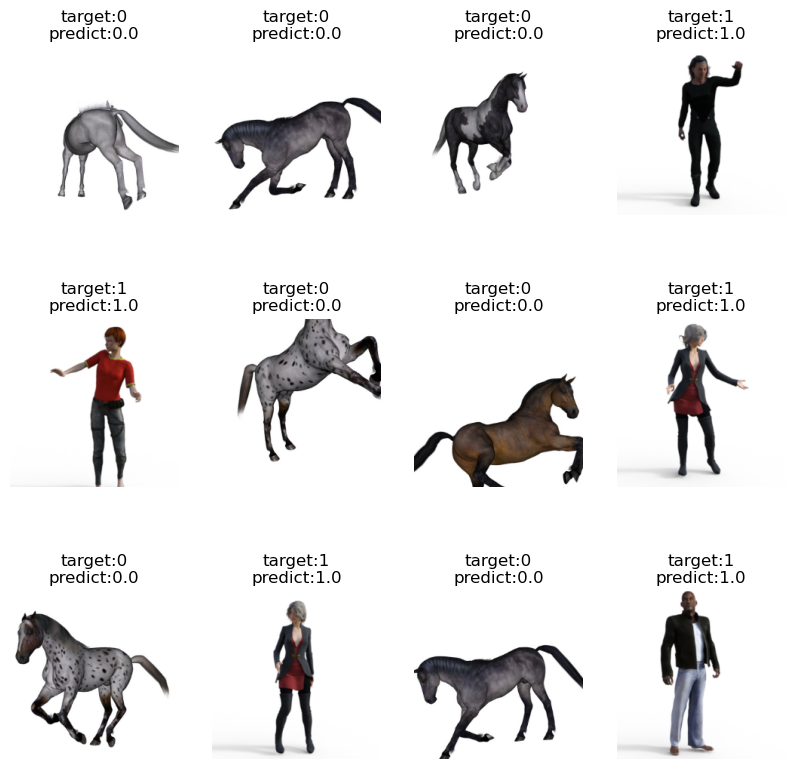

In [26]:
# Visualize predictions.
import matplotlib.pyplot as plt
# Predict 5 images from validation set.
n_images = 12
test_images = next(test)
predictions = model(test_images['x'])
plt.figure(figsize=(10, 10))
# Display image and model prediction.
for i in range(n_images):
    plt.subplot(3, 4, i+1)
    plt.imshow(test_images['x'][i], cmap='gray')
    plt.axis('off')
    plt.title('target:'+str(y_test[i])+'\n'+'predict:'+str(np.round(predictions.numpy()[i, 0], 2)))

## Svhn_cropped

In [6]:
train = tfds.load('svhn_cropped', split='train')
test = tfds.load('svhn_cropped', split='extra')

x_train, y_train, x_test, y_test = [], [], [], []
for i in train:
    a = i['image'].numpy()/255.0
    x_train.append(a)
    y_train.append(i['label'].numpy())
    
for i in test:
    a = i['image'].numpy()/255.0
    x_test.append(a)
    y_test.append(i['label'].numpy())

len(x_train), len(y_train), len(x_test), len(y_test)

(73257, 73257, 531131, 531131)

In [7]:
train = tf.data.Dataset.from_tensor_slices(dict(x=x_train, y=y_train)).repeat().batch(16)
test = tf.data.Dataset.from_tensor_slices(dict(x=x_test, y=y_test)).repeat().batch(16)
train = iter(train)
test = iter(test)

In [19]:
class NN(Model):
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = layers.Conv2D(8, 3, padding='same', activation=tf.nn.relu)
        self.pool = layers.MaxPooling2D(2)
        self.conv2 = layers.Conv2D(16, 3, padding='same', activation=tf.nn.relu)
        self.conv3 = layers.Conv2D(32, 3, padding='same', activation=tf.nn.relu)
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(1024, activation=tf.nn.relu)
        self.fc2 = layers.Dense(512, activation=tf.nn.relu)
        self.fc3 = layers.Dense(128, activation=tf.nn.relu)
        self.out = layers.Dense(10, activation=tf.nn.softmax)
        
    def call(self, x, is_training=False):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x

model = NN()
model.build(input_shape=(1, 32, 32, 3))
model.summary()

Model: "nn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           multiple                  224       
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           multiple                  1168      
                                                                 
 conv2d_5 (Conv2D)           multiple                  4640      
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_4 (Dense)             multiple                  2098176   
                                                              

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.losses.SparseCategoricalCrossentropy()

train_loss = tf.metrics.Mean(name='train_loss')
train_accuracy = tf.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.metrics.Mean(name='valid_loss')
test_accuracy = tf.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(ckpt, './svhn_checkpoints', max_to_keep=3)

In [21]:
@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        output = model(data['x'])
        loss = loss_object(data['y'], output)
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    train_loss(loss)
    train_accuracy(data['y'], output)
    return loss

@tf.function
def test_step(data):
    predictions = model(data['x'], training=False)
    t_loss = loss_object(data['y'], predictions)
    
    test_loss(t_loss)
    test_accuracy(data['y'], predictions)
    return t_loss

In [22]:
# Training process
def train_and_checkpoint(model, manager):
    for _ in range(math.ceil(len(x_train)/16)):
        example = next(train)
        loss = train_step(example)
        ckpt.step.assign_add(1)
        if int(ckpt.step) % 10 == 0:
            manager.save()
          # print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
          # print("loss {:1.2f}".format(loss.numpy()))

epochs = 10

ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

for i in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    train_and_checkpoint(model, manager)
    for _ in range(math.ceil(len(x_test)/16)):
        example = next(test)
        test_step(example)
    print(
      f'Epoch {i}, '
      f'Loss: {train_loss.result()}, '
      f'Accuracy: {train_accuracy.result() * 100}, '
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Initializing from scratch.
Epoch 0, Loss: 0.785209596157074, Accuracy: 74.01725006103516, Test Loss: 0.2898769974708557, Test Accuracy: 91.18643951416016
Epoch 1, Loss: 0.39330780506134033, Accuracy: 88.00093078613281, Test Loss: 0.24583087861537933, Test Accuracy: 92.81012725830078
Epoch 2, Loss: 0.304215669631958, Accuracy: 90.8481674194336, Test Loss: 0.2570475935935974, Test Accuracy: 93.06241607666016
Epoch 3, Loss: 0.24278639256954193, Accuracy: 92.72220611572266, Test Loss: 0.2690664827823639, Test Accuracy: 93.28307342529297
Epoch 4, Loss: 0.19599702954292297, Accuracy: 94.07894897460938, Test Loss: 0.30486181378364563, Test Accuracy: 93.46683502197266
Epoch 5, Loss: 0.16362281143665314, Accuracy: 94.960693359375, Test Loss: 0.35785973072052, Test Accuracy: 93.34012603759766
Epoch 6, Loss: 0.14241427183151245, Accuracy: 95.63359832763672, Test Loss: 0.3448658287525177, Test Accuracy: 93.3352279663086
Epoch 7, Loss: 0.12279129773378372, Accuracy: 96.15363311767578, Test Loss: 0.

In [23]:
tf.saved_model.save(model, 'models/svhn')

INFO:tensorflow:Assets written to: models/svhn/assets


INFO:tensorflow:Assets written to: models/svhn/assets


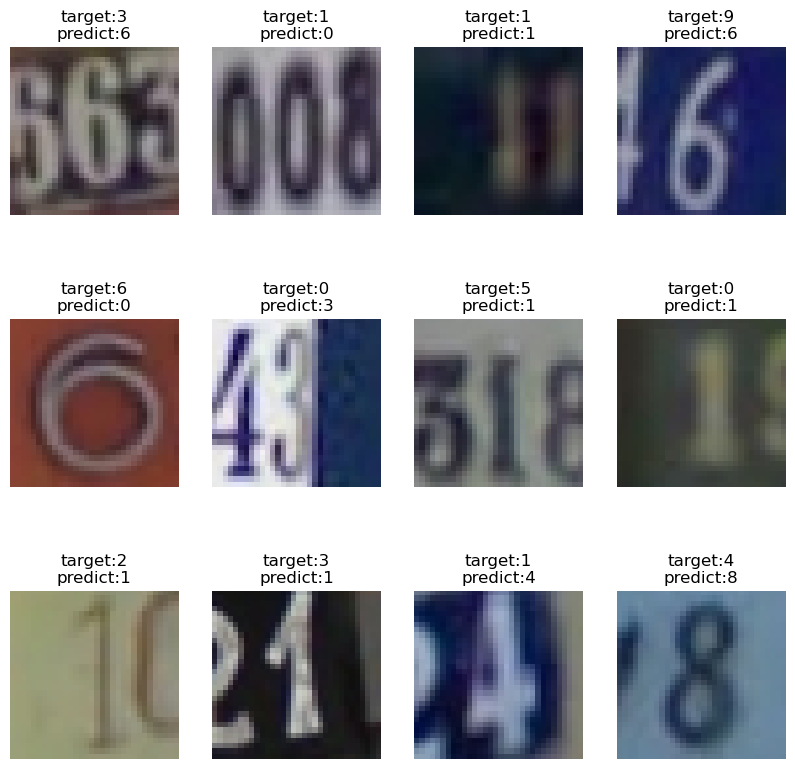

In [24]:
# Visualize predictions.
import matplotlib.pyplot as plt
# Predict 5 images from validation set.
n_images = 12
test_images = next(test)
predictions = model(test_images['x'])
plt.figure(figsize=(10, 10))
# Display image and model prediction.
for i in range(n_images):
    plt.subplot(3, 4, i+1)
    plt.imshow(test_images['x'][i], cmap='gray')
    plt.axis('off')
    plt.title('target:'+str(y_test[i])+'\n'+'predict:'+str(np.argmax(predictions.numpy()[i])))